In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Add the project root to the path
sys.path.append(os.path.abspath('ml_packing_system'))

from app.geometry.tree import ChristmasTree
from app.state.puzzle import PuzzleState, PuzzleManager
from app.state.storage import LayoutStorage
from app.geometry import calculate_score, calculate_bounding_square
from app.optimizers.hybrid import HybridOptimizer

print("Imports successful!")

Imports successful!


In [2]:
# Load the baseline CSV
csv_path = 'ml_packing_system/data/test.csv'
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    
    # Parse puzzle_id from id column (format: 001_0 -> puzzle_id=1)
    if 'id' in df.columns and 'puzzle_id' not in df.columns:
        try:
            df['puzzle_id'] = df['id'].apply(lambda x: int(x.split('_')[0]))
        except Exception as e:
            print(f"Error parsing puzzle_id: {e}")

    # Clean numeric columns if they contain 's' prefix (handling potential artifacts)
    for col in ['x', 'y', 'deg']:
        if col in df.columns and df[col].dtype == object:
            # Check if any value starts with 's'
            if df[col].astype(str).str.startswith('s').any():
                print(f"Cleaning column {col}...")
                df[col] = df[col].astype(str).str.replace('s', '').astype(float)
            
    print(f"Loaded {len(df)} rows from {csv_path}")
    display(df.head())
else:
    print(f"File not found: {csv_path}")

Cleaning column x...
Cleaning column y...
Cleaning column deg...
Loaded 20100 rows from ml_packing_system/data/test.csv


,id,x,y,deg,puzzle_id
0,001_0,-0.101560,0.069596,45.000000,1
1,002_0,-0.082115,-0.072677,113.630362,2
2,002_1,-0.605049,0.235518,-66.370914,2
3,003_0,1.017555,1.154083,155.134174,3
4,003_1,1.495723,0.756835,110.399030,3


In [3]:
def parse_puzzle_from_df(df, puzzle_id):
    """Extracts trees for a specific puzzle ID from the dataframe."""
    puzzle_rows = df[df['puzzle_id'] == puzzle_id]
    trees = []
    for _, row in puzzle_rows.iterrows():
        trees.append(ChristmasTree(row['x'], row['y'], row['deg']))
    return trees

def plot_puzzle(trees, title=None):
    """Plots the trees."""
    fig, ax = plt.subplots(figsize=(10, 10))
    
    for tree in trees:
        poly = Polygon(tree.polygon, closed=True, facecolor='green', edgecolor='darkgreen', alpha=0.7)
        ax.add_patch(poly)
        
    # Calculate bounds
    all_polys = [tree.polygon for tree in trees]
    if not all_polys:
        return
        
    all_points = np.vstack(all_polys)
    min_x, min_y = all_points.min(axis=0)
    max_x, max_y = all_points.max(axis=0)
    
    # Add some padding
    padding = 1.0
    ax.set_xlim(min_x - padding, max_x + padding)
    ax.set_ylim(min_y - padding, max_y + padding)
    ax.set_aspect('equal')
    
    if title:
        ax.set_title(title)
    
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

Found 200 trees for puzzle 200
Score: 0.38580472770266394


Found 200 trees for puzzle 200
Score: 0.38580472770266394


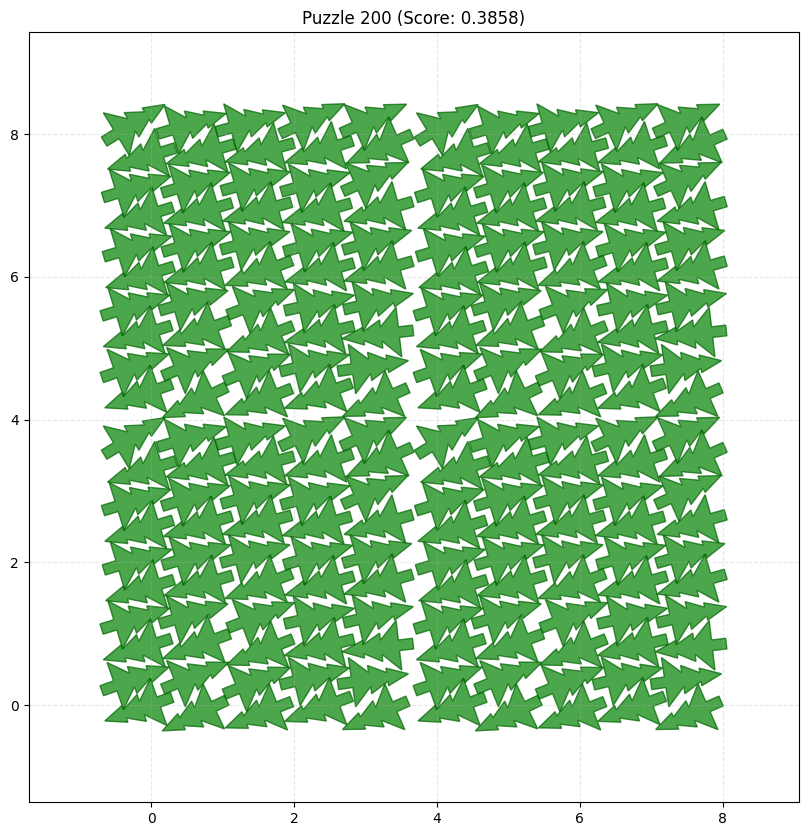

In [4]:
puzzle_id = 200
if 'puzzle_id' in df.columns and puzzle_id in df['puzzle_id'].values:
    trees_200 = parse_puzzle_from_df(df, puzzle_id)
    print(f"Found {len(trees_200)} trees for puzzle {puzzle_id}")
    score = calculate_score(trees_200)
    print(f"Score: {score}")
    plot_puzzle(trees_200, f"Puzzle {puzzle_id} (Score: {score:.4f})")
else:
    print(f"Puzzle {puzzle_id} not found in dataframe")

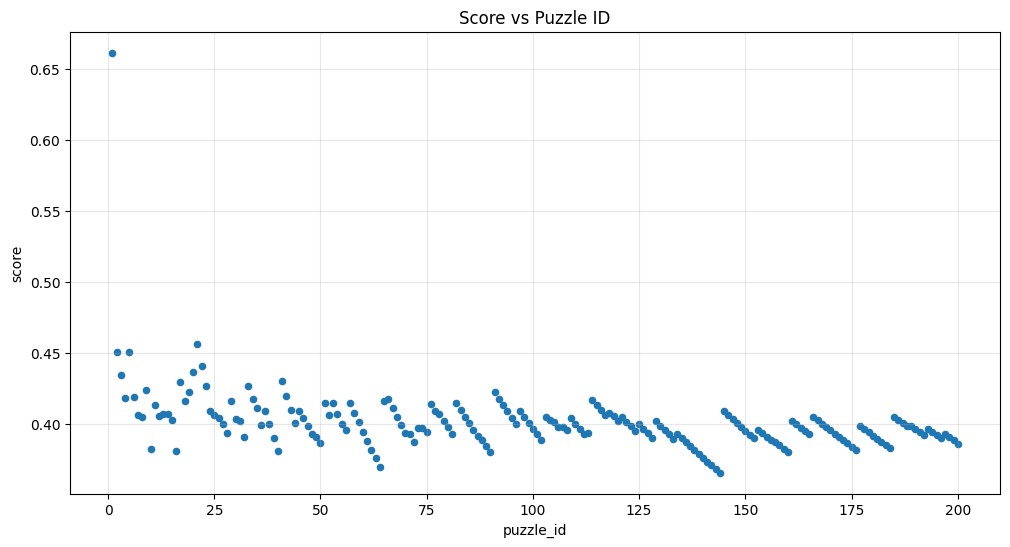

Total Score: 80.29897151327927


In [5]:
scores = []
for pid in sorted(df['puzzle_id'].unique()):
    trees = parse_puzzle_from_df(df, pid)
    score = calculate_score(trees)
    scores.append({'puzzle_id': pid, 'score': score})
    
scores_df = pd.DataFrame(scores)
scores_df.plot(x='puzzle_id', y='score', kind='scatter', title='Score vs Puzzle ID', figsize=(12, 6))
plt.grid(True, alpha=0.3)
plt.show()

print(f"Total Score: {scores_df['score'].sum()}")

Running optimization demo for Puzzle 5 (small example)...
Initial Score: 0.4509990482751836


Running optimization demo for Puzzle 5 (small example)...
Initial Score: 0.4509990482751836


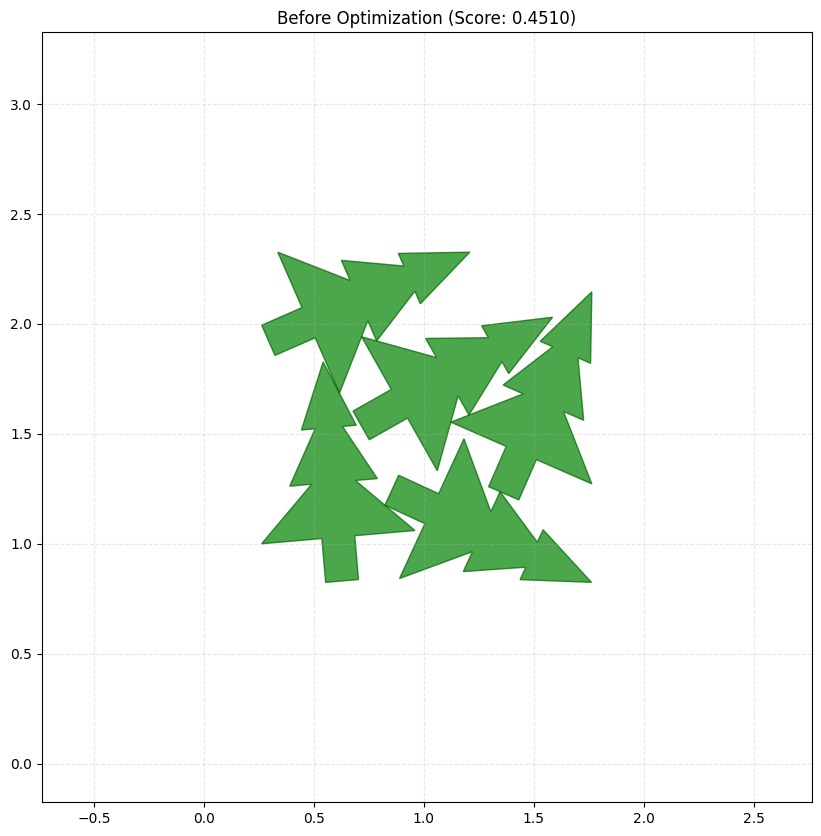

Running optimization demo for Puzzle 5 (small example)...
Initial Score: 0.4509990482751836


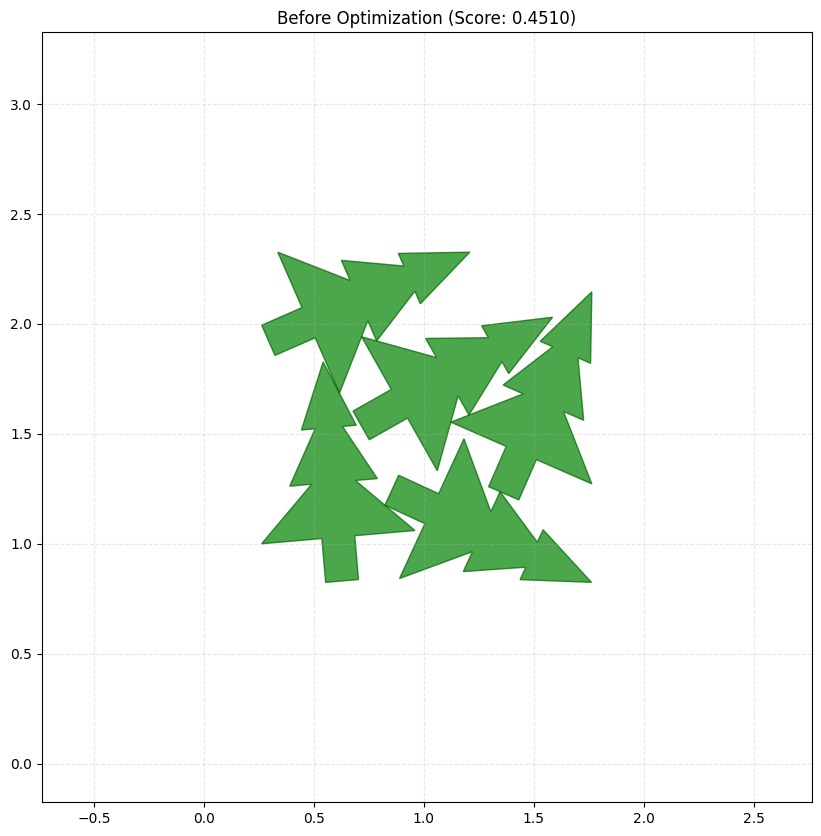

      [00:30:16] ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   2% | Iter 1/50 | Score: 0.450999 | Improv: 0 | HEURISTIC
      [00:30:16] █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   4% | Iter 2/50 | Score: 0.450999 | Improv: 0 | HEURISTIC
      [00:30:16] █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   6% | Iter 3/50 | Score: 0.450999 | Improv: 0 | HEURISTIC
      [00:30:16] ██░░░░░░░░░░░░░░░░░░░░░░░░░░░░   8% | Iter 4/50 | Score: 0.450999 | Improv: 0 | HEURISTIC
      [00:30:16] ███░░░░░░░░░░░░░░░░░░░░░░░░░░░  10% | Iter 5/50 | Score: 0.450999 | Improv: 0 | HEURISTIC
      [00:30:16] ███░░░░░░░░░░░░░░░░░░░░░░░░░░░  12% | Iter 6/50 | Score: 0.450999 | Improv: 0 | HEURISTIC
      [00:30:16] ████░░░░░░░░░░░░░░░░░░░░░░░░░░  14% | Iter 7/50 | Score: 0.450999 | Improv: 0 | HEURISTIC
      [00:30:16] ████░░░░░░░░░░░░░░░░░░░░░░░░░░  16% | Iter 8/50 | Score: 0.450999 | Improv: 0 | HEURISTIC
      [00:30:16] █████░░░░░░░░░░░░░░░░░░░░░░░░░  18% | Iter 9/50 | Score: 0.450999 | Improv: 0 | HEURISTIC
      [00:30:16] ██████░░░░░░░░░░░░░░

Running optimization demo for Puzzle 5 (small example)...
Initial Score: 0.4509990482751836


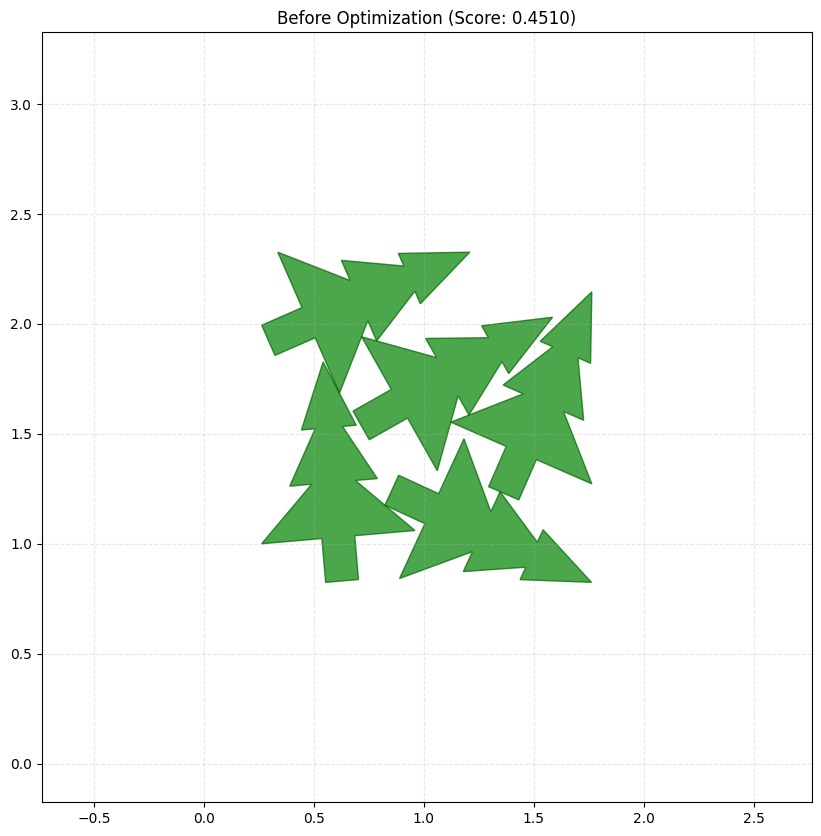

      [00:30:16] ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   2% | Iter 1/50 | Score: 0.450999 | Improv: 0 | HEURISTIC
      [00:30:16] █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   4% | Iter 2/50 | Score: 0.450999 | Improv: 0 | HEURISTIC
      [00:30:16] █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░   6% | Iter 3/50 | Score: 0.450999 | Improv: 0 | HEURISTIC
      [00:30:16] ██░░░░░░░░░░░░░░░░░░░░░░░░░░░░   8% | Iter 4/50 | Score: 0.450999 | Improv: 0 | HEURISTIC
      [00:30:16] ███░░░░░░░░░░░░░░░░░░░░░░░░░░░  10% | Iter 5/50 | Score: 0.450999 | Improv: 0 | HEURISTIC
      [00:30:16] ███░░░░░░░░░░░░░░░░░░░░░░░░░░░  12% | Iter 6/50 | Score: 0.450999 | Improv: 0 | HEURISTIC
      [00:30:16] ████░░░░░░░░░░░░░░░░░░░░░░░░░░  14% | Iter 7/50 | Score: 0.450999 | Improv: 0 | HEURISTIC
      [00:30:16] ████░░░░░░░░░░░░░░░░░░░░░░░░░░  16% | Iter 8/50 | Score: 0.450999 | Improv: 0 | HEURISTIC
      [00:30:16] █████░░░░░░░░░░░░░░░░░░░░░░░░░  18% | Iter 9/50 | Score: 0.450999 | Improv: 0 | HEURISTIC
      [00:30:16] ██████░░░░░░░░░░░░░░

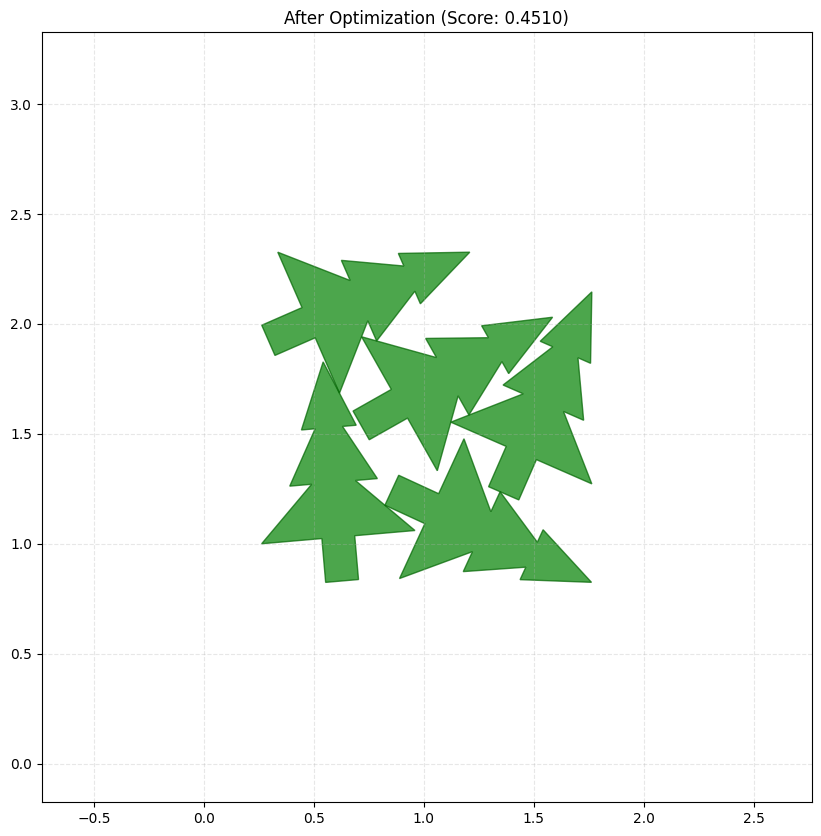

In [7]:
# Optimization Demo
print("Running optimization demo for Puzzle 5 (small example)...")

# Create a small puzzle state
n = 5
trees = parse_puzzle_from_df(df, n) if n in df['puzzle_id'].values else []
if not trees:
    # Initialize random if not in CSV
    from app.optimizers.initializer import initialize_puzzle
    state = initialize_puzzle(n, method='greedy')
else:
    state = PuzzleState(
        n=n,
        trees=trees,
        score=calculate_score(trees),
        side_length=calculate_bounding_square(trees)
    )

print(f"Initial Score: {state.score}")
plot_puzzle(state.trees, f"Before Optimization (Score: {state.score:.4f})")

# Run Optimizer
optimizer = HybridOptimizer(use_ml=False) # Disable ML for quick demo without model loading
optimized_state = optimizer.optimize_puzzle(state, max_iterations=50, verbose=True)

print(f"Final Score: {optimized_state.score}")
plot_puzzle(optimized_state.trees, f"After Optimization (Score: {optimized_state.score:.4f})")